# Home Credit Default Risk

# Library used

In [251]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import graphviz

# Machine Learning Library
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import joblib

# Logistic Regression
from sklearn.linear_model import LogisticRegression

from warnings import filterwarnings
filterwarnings('ignore')

## Data

In [219]:
app_train = pd.read_csv("./resources/application_train.csv", encoding='utf-8', sep=',')
app_test = pd.read_csv("./resources/application_test.csv", encoding='utf-8', sep=',')
app_train.drop_duplicates()
app_test.drop_duplicates()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


## Aligning the two datasets

In [220]:
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


# Data Analysis

In [221]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

## Is data unbalanced ? 

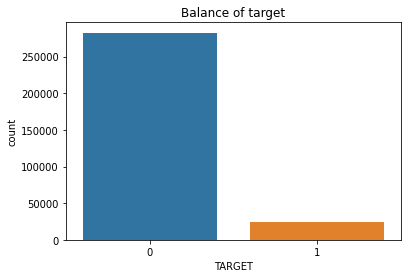

In [222]:
fig = sns.countplot(x="TARGET", data=app_train)
plt.title('Balance of target')
plt.show()

The data is very unbalanced.

## Missing values

In [223]:
(app_train.isnull().sum()/app_train.shape[0])*100

SK_ID_CURR                     0.000000
NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.000000
FLAG_OWN_CAR                   0.000000
FLAG_OWN_REALTY                0.000000
                                ...    
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
TARGET                         0.000000
Length: 122, dtype: float64

## Label encoding

In [224]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        le.fit(app_train[col])
        app_train[col] = le.transform(app_train[col])
        app_test[col] = le.transform(app_test[col])
        le_count += 1
        print(col)
app_train.reset_index()
app_test.reset_index()
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
16 columns were label encoded.


## Missing and infinite values

In [225]:
app_train.replace([np.inf, -np.inf], np.nan, inplace=True)
app_train.dropna(inplace= True)

app_test.replace([np.inf, -np.inf], np.nan, inplace=True)
app_test.dropna(inplace= True)

In [226]:
(app_train.isnull().sum()/app_train.shape[0])*100

SK_ID_CURR                    0.0
NAME_CONTRACT_TYPE            0.0
CODE_GENDER                   0.0
FLAG_OWN_CAR                  0.0
FLAG_OWN_REALTY               0.0
                             ... 
AMT_REQ_CREDIT_BUREAU_WEEK    0.0
AMT_REQ_CREDIT_BUREAU_MON     0.0
AMT_REQ_CREDIT_BUREAU_QRT     0.0
AMT_REQ_CREDIT_BUREAU_YEAR    0.0
TARGET                        0.0
Length: 122, dtype: float64

# Data cleanup 

## Days Birth feature

### Informations

In [227]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    11351.000000
mean        39.680914
std          9.719917
min         21.117808
25%         32.073973
50%         38.435616
75%         45.924658
max         68.542466
Name: DAYS_BIRTH, dtype: float64

### Minimum and maximum value

In [228]:
mini = abs(app_train['DAYS_BIRTH'].max())
if mini > 365:
    print("Days birth min :", mini/365, "days" )
else:
    print("Days birth min :", mini, "days" )
    
maxi = abs(app_train['DAYS_BIRTH'].min())
print("Days birth max :", maxi/365, "years" )

Days birth min : 21.117808219178084 days
Days birth max : 68.54246575342465 years


### Boxplots

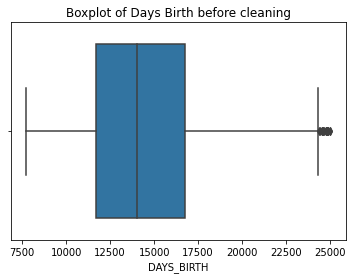

In [229]:
ax = sns.boxplot(x=abs(app_train['DAYS_BIRTH']))
plt.title('Boxplot of Days Birth before cleaning')
plt.show()

## Days Employed feature

### Informations 

In [230]:
app_train['DAYS_EMPLOYED'].describe()

count     11351.000000
mean      17310.202802
std       82583.957313
min      -15183.000000
25%       -3010.500000
50%       -1573.000000
75%        -679.500000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

### Minimum and maximum values

In [231]:
mini = abs(app_train['DAYS_EMPLOYED'].max())
if mini > 365:
    print("Days employed min :", mini/365, "days" )
else:
    print("Days employed min :", mini, "days" )
    
maxi = abs(app_train['DAYS_EMPLOYED'].min())
print("Days employed max :", maxi/365, "years" )

Days employed min : 1000.6657534246575 days
Days employed max : 41.5972602739726 years


### Boxplots

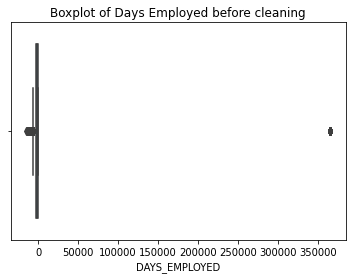

In [232]:
ax = sns.boxplot(x=app_train['DAYS_EMPLOYED'])
plt.title('Boxplot of Days Employed before cleaning')
plt.show()

##### Removing anomalies

In [233]:
app_train.drop(app_train.index[(app_train["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)
app_test.drop(app_test.index[(app_test["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)

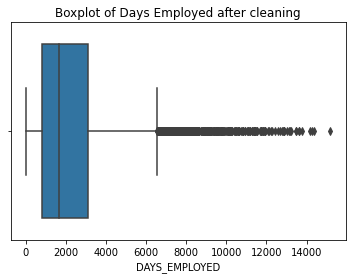

In [234]:
ax = sns.boxplot(x=abs(app_train['DAYS_EMPLOYED']))
plt.title('Boxplot of Days Employed after cleaning')
plt.show()

# Making our model

## Correlations

In [235]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n\n', correlations.tail(15))
print('\nMost Negative Correlations:\n\n', correlations.head(15))

Most Positive Correlations:

 CODE_GENDER                    0.030246
NAME_HOUSING_TYPE              0.031263
AMT_REQ_CREDIT_BUREAU_YEAR     0.033651
NAME_INCOME_TYPE               0.034980
OWN_CAR_AGE                    0.038692
DAYS_BIRTH                     0.044388
FLAG_DOCUMENT_3                0.054081
REGION_RATING_CLIENT           0.054562
DAYS_EMPLOYED                  0.059680
NAME_EDUCATION_TYPE            0.059891
REGION_RATING_CLIENT_W_CITY    0.062584
TARGET                         1.000000
FLAG_OWN_CAR                        NaN
FLAG_MOBIL                          NaN
FLAG_DOCUMENT_2                     NaN
Name: TARGET, dtype: float64

Most Negative Correlations:

 EXT_SOURCE_3           -0.157021
EXT_SOURCE_2           -0.137090
EXT_SOURCE_1           -0.133328
FLOORSMAX_AVG          -0.047756
FLOORSMAX_MODE         -0.047479
FLOORSMAX_MEDI         -0.047193
AMT_INCOME_TOTAL       -0.046054
NAME_CONTRACT_TYPE     -0.041389
FLOORSMIN_MEDI         -0.032337
FLOORSMIN_AVG

# Splitting data into train and validation

In [236]:
Xdf = app_train
Xdf.drop("TARGET", axis = 1)
X = np.array(Xdf)

y = np.array(app_train["TARGET"])

In [248]:
# Recommended test sizes for crossvalidation : [20, 25, 30]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)

# Logistic regression

Our problem is a very binary one : will someone repay their credit or won't they ? 

This is why we use logistic regression as our machine learning model.

### Model training

In [238]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Model testing

In [239]:
predictions = model.predict(X_test)
print("Predictions:\n\n", predictions, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0 0 0 ... 0 0 0] 

Real values:

 [0 1 0 ... 0 0 0]


### Model evaluation

In [240]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2523
           1       0.00      0.00      0.00       164

    accuracy                           0.94      2687
   macro avg       0.47      0.50      0.48      2687
weighted avg       0.88      0.94      0.91      2687



In [241]:
print("Accuracy score:", round((accuracy_score(y_test, predictions)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 93.9 %

Accuracy score using cross validation: 93.88 %



In [242]:
print("Precision score:", round((precision_score(y_test, predictions, average='macro')*100), 2), '%\n')

Precision score: 46.95 %



### Confusion matrix

In [256]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
cnf_matrix

array([[2523,    0],
       [ 164,    0]], dtype=int64)

The confusion matrix shows us the number of : 
* True positives: 2523
* True negatives: 0
* False positives: 164
* False negatives: 0

### ROC Curve

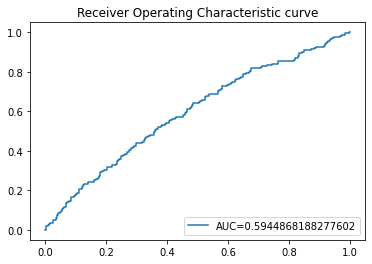

In [255]:
prediction_prob = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob)
auc = metrics.roc_auc_score(y_test, prediction_prob)

#create ROC curve
plt.title("Receiver Operating Characteristic curve")
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

This curve displays the percentage of true positives predicted by the model as the prediction probability cutoff is lowered from 1 to 0.

The higher the AUC (area under the curve), the more accurately our model is able to predict outcomes.